# Mini Project - Scorberr - Scott Berry
I am captain of an amateur pool team and every week we play opponents attempting to score enough points to qualify for the playoffs

In the league there are skill levels 2-7 depending on how good the player is. In a given night, each team can play 23 total points between their 5 players. The captain dilemma is how to optimize matchups to favor your own team

I wrote a linear regression model previously but my teammates expressed concern that the model would only help over the course of a full session, not individual matches.

Once playoffs are reached, point accumulation is no longer important, a matchup of 5 players determines who progresses, we can't afford to play the long-game numbers. This is a common failure in "moneyball" teams once the playoffs are eventually reached.

With this notebook I intend to create a classification prediction that can be more reliable in the low-sample size playoff matchups

## Import dependencies

In [183]:
import numpy as np
import openpyxl
import pandas as pd
from matplotlib import pyplot as plt
from torch.autograd import Variable
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Add Excel Workbook to Pandas DF function
Helper function that allows importing Excel Workbooks

In [184]:
def workbook2df(path, first_row_header, first_column_index):
    workbook = openpyxl.load_workbook(path).active
    rows = list(workbook.iter_rows(values_only=True))
    df = pd.DataFrame(rows)
    if first_row_header:
        new_header = df.iloc[0]
        df = df[1:]
        df.columns = new_header
    if first_column_index:
        df = df.set_index("SL")
    return df

## Import Data
Importing a full-year data of Skill Level matchups across all the teams in my division

In [185]:
games_to_win = workbook2df("data/gamesToWin.xlsx", True, True)
sl_matchup_data = workbook2df("data/slmatchups/SLMatchups.xlsx", True, False)

## Get Expected Points in every Skill Level matchup
Non-ML method, I am simply creating this for context of what a helpful tool in the league looks like

This is simply what ACTUALLY happened for all teams over the past year

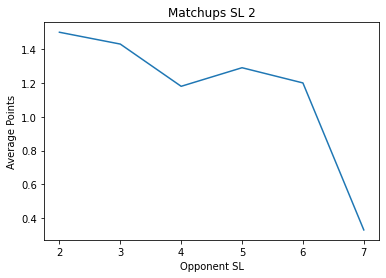

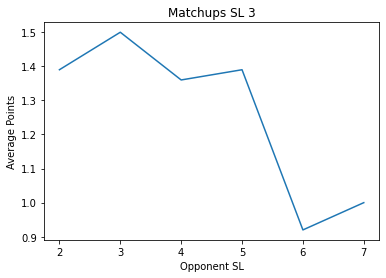

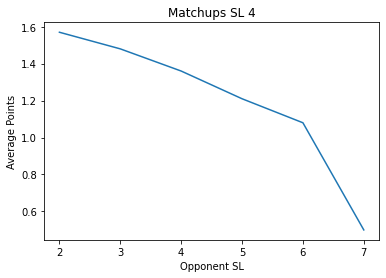

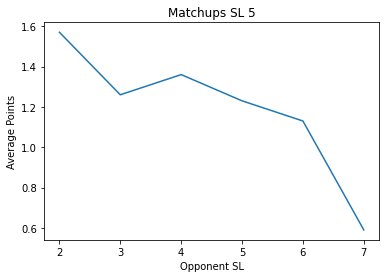

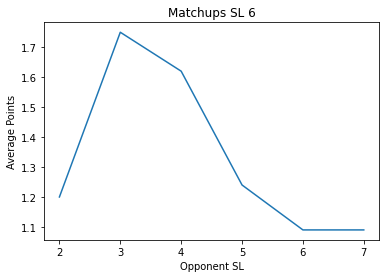

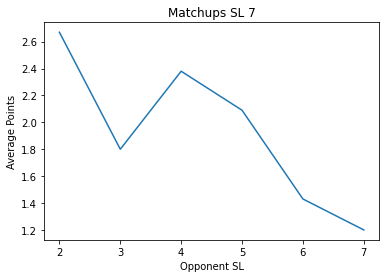

0      2     3     4     5     6     7
SL                                    
2    1.5  1.43  1.18  1.29   1.2  0.33
3   1.39   1.5  1.36  1.39  0.92   1.0
4   1.57  1.48  1.36  1.21  1.08   0.5
5   1.57  1.26  1.36  1.23  1.13  0.59
6    1.2  1.75  1.62  1.24  1.09  1.09
7   2.67   1.8  2.38  2.09  1.43   1.2


In [186]:
class SLMatches:
    def __init__(self, SL, opponentSL):
        self.SL = SL
        self.opponentSL = opponentSL
        self.points = 0
        self.games = 0
        self.indices_checked = []
        self.average = None

    def addpoints(self, points):
        self.points += points

    def addgame(self, index):
        self.games += 1
        self.indices_checked.append(index)

    def getaverage(self):
        try:
            self.average = self.points / self.games
        except ZeroDivisionError:
            self.average = None

def get_sl_matchup_stats(df, games2win):
    slmatches = games2win
    slrange = range(2, 8)
    for p1skill in slrange:
        for p2skill in slrange:
            matchup_data = SLMatches(p1skill, p2skill)
            for index, row in df.iterrows():
                if row['Player_1'] == p1skill and row['Player_2'] == p2skill:
                    matchup_data.addpoints(row['Points_1'])
                    matchup_data.addgame(index)
                    if p1skill == p2skill:
                        matchup_data.addpoints(row['Points_2'])
            for index, row in df.iterrows():
                if index not in matchup_data.indices_checked:
                    if row['Player_2'] == p1skill and row['Player_1'] == p2skill:
                        matchup_data.addpoints(row['Points_2'])
                        matchup_data.addgame(index)
            matchup_data.getaverage()
            if p1skill == p2skill:
                matchup_data.average /= 2
            slmatches.loc[p1skill, p2skill] = round(matchup_data.average, 2)
    for sl in slrange:
        plt.plot(np.array(slrange), np.array([x for x in slmatches.values[sl-2]]))
        title = 'Matchups SL {}'.format(sl)
        imgtitle = "data/slmatchups/slmatchups{}.jpg".format(sl)
        plt.title(title)
        plt.xlabel('Opponent SL')
        plt.ylabel('Average Points')
        plt.savefig(imgtitle)
        plt.show()
    slmatches.to_excel(r'data/slmatchups/SLMatchupAverages.xlsx', index=True, header=True)
    print(slmatches)


get_sl_matchup_stats(sl_matchup_data, games_to_win)

### Predict Win Result based on my own team's game data this past session
Use multiple model types to attempt to predict wins or losses with specific matchups

Matchups predicted to be wins by both models are likely to be the best matchups to pursue

## Importing the dataset
The y values are the binary yes/no match won

The shape of the dataset is set to the num variables

In [187]:
games = workbook2df("data/wookieMistakesSpring2022Games.xlsx", True, False)
game_data = games.drop(columns=["Week", "Name"]).astype(float)

X = game_data.iloc[:, :-1].values
y = game_data.iloc[:, -1].values

num_games = game_data.shape[0]
num_categories = game_data.shape[1]

## Feature Scaling
This normalizes the data to put all values between 0 and 1

In [188]:
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

## Split into train/test and convert to Torch tensors
Data is split 80/20 into Torch tensors

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
training_set = np.hstack((X_train, y_train.reshape((y_train.shape[0],1))))
test_set = np.hstack((X_test, y_test.reshape((y_test.shape[0],1))))
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

## Create AutoEncoder Neural Network
This model inherits from Torch Neural Network with some modified values/methods

Different optimizers affect model loss due to their effect on learning rate and weights

The example on Canvas used the RMSprop optimizer (a gradient descent variant) due to ability to increase learning rate reliably and as such will be used in this notebook

The Adam optimizer is the ideal choice in most datasets, however, the main reasons being the faster compute time which can increase the number of epochs and easier parameter tuning

In [190]:
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(num_categories, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, num_categories)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

## Train the AutoEncoder
AE model is trained over 200 epochs for each value in the train set

With too few epochs loss is not minimized, too many and the model will be over-fitted

In [191]:
num_epoch = 200
for epoch in range(1, num_epoch + 1):
    train_loss = 0
    s = 0.
    for game_id in range(num_games):
        try:
            input = Variable(training_set[game_id]).unsqueeze(0)
            target = input.clone()
            if torch.sum(target.data > 0) > 0:
                output = sae(input)
                target.require_grad = False
                output[target == 0] = 0
                loss = criterion(output, target)
                mean_corrector = num_categories / float(torch.sum(target.data > 0) + 1e-10)
                loss.backward()
                train_loss += np.sqrt(loss.data*mean_corrector)
                s += 1.
                optimizer.step()
        except IndexError:
            s += 1.
            optimizer.step()
    print('epoch: '+str(epoch)+' loss: '+ str(train_loss/s))

epoch: 1 loss: tensor(0.2410)
epoch: 2 loss: tensor(0.1941)
epoch: 3 loss: tensor(0.1853)
epoch: 4 loss: tensor(0.1829)
epoch: 5 loss: tensor(0.1818)
epoch: 6 loss: tensor(0.1809)
epoch: 7 loss: tensor(0.1802)
epoch: 8 loss: tensor(0.1797)
epoch: 9 loss: tensor(0.1805)
epoch: 10 loss: tensor(0.1818)
epoch: 11 loss: tensor(0.1837)
epoch: 12 loss: tensor(0.1839)
epoch: 13 loss: tensor(0.1835)
epoch: 14 loss: tensor(0.1836)
epoch: 15 loss: tensor(0.1842)
epoch: 16 loss: tensor(0.1848)
epoch: 17 loss: tensor(0.1851)
epoch: 18 loss: tensor(0.1855)
epoch: 19 loss: tensor(0.1849)
epoch: 20 loss: tensor(0.1846)
epoch: 21 loss: tensor(0.1846)
epoch: 22 loss: tensor(0.1847)
epoch: 23 loss: tensor(0.1845)
epoch: 24 loss: tensor(0.1847)
epoch: 25 loss: tensor(0.1843)
epoch: 26 loss: tensor(0.1841)
epoch: 27 loss: tensor(0.1840)
epoch: 28 loss: tensor(0.1838)
epoch: 29 loss: tensor(0.1833)
epoch: 30 loss: tensor(0.1833)
epoch: 31 loss: tensor(0.1825)
epoch: 32 loss: tensor(0.1824)
epoch: 33 loss: t

## Test the AutoEncoder
The testing computes a total test loss value by comparing the test set to output of the AE model

The relatively low test loss result indicates that this classifier can predict match results

The wins in the test set are outputted based on wins that SHOULD have been losses set at a threshold of 0.06 loss

In [192]:
test_loss = 0
s = 0.
wins_ann = []
for game_id in range(num_games):
    try:
        input = Variable(training_set[game_id]).unsqueeze(0)
        target = Variable(test_set[game_id]).unsqueeze(0)
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            if loss > 0.06:
                wins_ann.append(game_id)
            mean_corrector = num_categories / float(torch.sum(target.data > 0) + 1e-10)
            test_loss += np.sqrt(loss.data*mean_corrector)
            s += 1.
    except IndexError:
        s += 1.
print('test loss: '+str(test_loss/s))
print("Game IDs of predicted wins: " + str(wins_ann))

test loss: tensor(0.0538)
Game IDs of predicted wins: [2, 3, 6, 8, 11, 12]


## Create the Boltzmann Machine
This RBM class is created by specifying weights, hidden and visible nodes

Further, the training method is specified here with batches of 100

In [193]:
class RBM:
    def __init__(self, nv, nh):
        self.W = torch.randn(nh, nv)
        self.a = torch.randn(1, nh)
        self.b = torch.randn(1, nv)
    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    def train(self, v0, vk, ph0, phk):
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)
nv = len(training_set[0])
nh = 100
batch_size = 100
rbm = RBM(nv, nh)

## Train the Boltzmann Machine
The RBM model is trained over the batches of the training set for the length of the training set

In [194]:
num_epoch = 7
for epoch in range(1, num_epoch + 1):
    train_loss = 0
    s = 1e-9
    for game_id in range(0, num_games - batch_size, batch_size):
        vk = training_set[game_id: game_id + batch_size]
        v0 = training_set[game_id: game_id + batch_size]
        ph0,_ = rbm.sample_h(v0)
        for k in range(10):
            _,hk = rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        phk,_ = rbm.sample_h(vk)
        rbm.train(v0, vk, ph0, phk)
        train_loss += torch.mean(torch.abs(v0[v0 >= 0] - vk[v0 >= 0]))
        s += 1.
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: 0.0
epoch: 2 loss: 0.0
epoch: 3 loss: 0.0
epoch: 4 loss: 0.0
epoch: 5 loss: 0.0
epoch: 6 loss: 0.0
epoch: 7 loss: 0.0


## Test the Boltzmann Machine
The testing set is compared to the RBM model

The low test loss result is indicative of the model performing better than the AE model

Each win is printed when loss is found at a threshold of 0.50

In [195]:
test_loss = 0
s = 0.
wins_rbm = []
for game_id in range(num_games):
    v = training_set[game_id:game_id + 1]
    vt = test_set[game_id:game_id + 1]
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(v)
        _,v = rbm.sample_v(h)
        if torch.mean(torch.abs(vt[vt>=0] - v[vt>=0])) > 0.50:
            wins_rbm.append(game_id)
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        s += 1.
print('test loss: '+str(test_loss/s))
print("Game IDs of predicted wins: " + str(wins_rbm))

test loss: tensor(0.5239)
Game IDs of predicted wins: [0, 3, 4, 5, 6, 8, 10, 11]


## Identify Wins selected by both models
These are the matchups that I will attempt to exploit in playoff matches

In [196]:
wins = []
for win in wins_ann:
    if win in wins_rbm:
        wins.append(win)
print("Wins predicted by both models: " + str(wins))

Wins predicted by both models: [3, 6, 8, 11]
